<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/main/Zemlyakov_Serj/Int_1_%D0%9F%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3_2_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Работа с массивами данных
import numpy as np 

# Работа с табличными данными
import pandas as pd

import string

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

import random

# Отрисовка графиков
import matplotlib.pyplot as plt

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

!pip install tensorflow-addons

import tensorflow_addons as tfa

from tensorflow_addons.metrics import F1Score

%matplotlib inline



In [1]:
# Mount Google Drive
import os
from google.colab import drive

drive.mount('/content/drive')
!pwd
!ls



Mounted at /content/drive
/content
drive  sample_data


In [2]:
# Загрузка базы данных заказчика, предварительно сохарненной в формате *.csv
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/internsheep1/profpat_1.csv')


<ipython-input-2-fc7b980cb21a>:2: DtypeWarning: Columns (24,25,26,43,44,45,46,47,48,54,55,56,57,58,59,60,61,62,63,64,65,77,78,79,81,84,85,86,87,88,89,90,91,92,108,109,112,113,120,121,122,123,124,125,126,127,162,163,164,168,169,170,171,172,173,174,195,196,201,202,203,204,205,206,207,208,221,222,223,228,229,230,252,253,258,259,260,261,262,263,264,265,266,267,270,271,272,273,276,277,278,279,282,283,284,285,286,287,293,294,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,363,364,365,366,367,370,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,418,419,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,470,471,472,483,484,485,486,491,492,514,515,549,550,551,552,553,554,555,564,565,578,579,580,581,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,6

In [4]:
# Вспомогательные функции для очистки строковых данных для приведения к удобномы для обратки виду
def purify(x):
    if isinstance(x, str):                # Если значение - строка:
        # Замена концов строк на пробелы, удаление символа с кодом 0xA0,
        # обрезка краевых пробелов и приведение к нижнему регистру
        x1 = re.sub(r',\s*(?=,|$)', '', x).strip(',')
    return x1

def clean_string(text): 
    # удаление знаков препинания
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text    

In [72]:
def clean_dict(dict_d):
  advanceddict = {}
  for key in dict_d:
    # проверяем, есть ли в ключе разделитель ","
    if re.search(',', key):
      # если есть, то разделяем ключ на список из отдельных ключей
      subkeys = key.split(',')
      # для каждого нового ключа создаем запись в новом словаре
      for subkey in subkeys:
        # копируем значение из старого словаря
        advanceddict[subkey] = dict_d[key]
    else:
      # если разделителя нет, то просто копируем ключ и значение
      advanceddict[key] = dict_d[key]

  return advanceddict

In [7]:
# Исходный размер таблицы данных
print(df.shape)

(1982, 4587)


In [8]:
# Подготовка таблицы данных
# Убираем полностью пустые строки
dffix1 = df.dropna(axis=1, how='all')

# Убираем строки в которых отстутствует одно из встреченных заключений Профпатолога (ПП)
dffix1 = dffix1[dffix1['ЗаключениеМК'].isin(['Годен',
                                    'ГоденСКоррекциейЗрения',
                                    'ВременноНегоден',
                                    'НуждаетсяВДообследованииИЛечении',
                                    'ОграниченноГоден',
                                    'ГоденБезРаботНаВысотах'])]

# Приводим к 3-м классам (Годен, Негоден, ОграниченноГоден)
dffix1.loc[dffix1['ЗаключениеМК'] == 'ВременноНегоден', 'ЗаключениеМК'] = 'Негоден'
dffix1.loc[dffix1['ЗаключениеМК'] == 'НуждаетсяВДообследованииИЛечении', 'ЗаключениеМК'] = 'Негоден'
dffix1.loc[dffix1['ЗаключениеМК'] == 'ГоденСКоррекциейЗрения', 'ЗаключениеМК'] = 'ОграниченноГоден'
dffix1.loc[dffix1['ЗаключениеМК'] == 'ГоденБезРаботНаВысотах', 'ЗаключениеМК'] = 'ОграниченноГоден'

# Для удобства обращения к столбцу, переименуем его в название из одного слова
dffix1.rename(columns = {'Вредные Факторы':'Вредность'}, inplace = True )

# Оставляем только значащие для нас колонки: Заключение ПП, Вредность и Диагнозы узких специалистов в текстовом представлении
dffix1 = dffix1[['ЗаключениеМК',
'Вредность',
'Психиатрия Наркология1 Диагноз Представление1',
'Офтальмология1_ДиагнозПредставление1',
'Оториноларингология1_ДиагнозПредставление1',
'Гинекология1_ДиагнозПредставление1',
'Стоматология1_ДиагнозПредставление1',
'Дерматовенерология1_ДиагнозПредставление1',
'Неврология1_ДиагнозПредставление1',
'Терапия1_ДиагнозПредставление1',
'Хирургия1_ДиагнозПредставление1',
'Офтальмология1_ДиагнозПредставление2',
'Терапия2_ДиагнозПредставление1',
]]

# Заменяем отсутсвтующие записи узких специалистов в пробелы
dffix1=dffix1.fillna('')

# Вывод количества и числа признаков
print(dffix1.shape)


(1571, 13)


In [9]:
# Обобщенный диагноз - собирем диагнозы узких специалистов в одну строку через запятую
dffix1['Свод_Диагноз'] = (dffix1['Психиатрия Наркология1 Диагноз Представление1'].map(str) + ','
 + dffix1['Офтальмология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Оториноларингология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Гинекология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Стоматология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Дерматовенерология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Неврология1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Терапия1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Хирургия1_ДиагнозПредставление1'].map(str)+ ','
 + dffix1['Офтальмология1_ДиагнозПредставление2'].map(str)+ ','
 + dffix1['Терапия2_ДиагнозПредставление1'].map(str))

In [19]:
# Упрвостим таблицу данных до 3-х столбцов
dffix2 = dffix1[['ЗаключениеМК',
                        'Вредность',
                        'Свод_Диагноз',
]]

print (dffix2.shape)

(1571, 3)


In [13]:
# Подготовка строковых данных в колонке сводного диагноза
# Получим список всех сводных диагнозов для 1571 записи 
list_of_Diag = dffix2['Свод_Диагноз'].tolist()
# print (list_of_Diag)

# Используя заготовленную функцию, очистим каждую строку от "мусора"
clearlist=[]
for A in list_of_Diag:
  clearlist.append(purify(A))
# print (clearlist)


In [20]:
# Поместим в новую колонку очищенные строки из полученного списка
dffix2['Диагнозы'] = True
dffix2['Диагнозы'] = clearlist

# Получаем новую таблицу данных
dffix3=dffix2[['ЗаключениеМК',
                        'Вредность',
                        'Диагнозы']]

# Удаляем строки с отстуствующими записями всех узких специалистов                    
dffix3 = dffix3[dffix3['Диагнозы']!='']

print (dffix3.shape)


(1420, 3)


<ipython-input-20-6db415f62ae3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffix2['Диагнозы'] = True
<ipython-input-20-6db415f62ae3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dffix2['Диагнозы'] = clearlist


In [22]:
# Данные по распределению представителей классов
dffix3.ЗаключениеМК.value_counts()

Годен               1284
ОграниченноГоден     125
Негоден               11
Name: ЗаключениеМК, dtype: int64

In [24]:
CLASS_COUNT = dffix3['ЗаключениеМК'].nunique()

# Задаем словарь классов
CLASS_DICT ={'Негоден':0, 'ОграниченноГоден':1, 'Годен':2}

CLASS_LIST = dffix3.ЗаключениеМК.value_counts()

# Создаем метрику для разбалансированных классов
custum_metric = tfa.metrics.F1Score(num_classes=CLASS_COUNT, average="micro", threshold=0.5, name='F1Score' )

In [25]:
# Функция извлечения данных о вредных факторах

def extract_harm_text(row_list):
    result = []
    
    # Для всех строк таблицы: собрать значения 
    # столбцов вредности
   
    
    for row in row_list:
                    result.append(str(row[COL_HARM]).split(','))
    
    # Возврат в виде массива
    return result

In [26]:
# Функция извлечения данных о Диагнозе

def extract_Diag_text(row_list):
    result = []
    
    # Для всех строк таблицы: собрать значения сводного МКБ
   
    
    for row in row_list:
                    result.append(str(row[COL_DIAG]).split(','))
    
    # Возврат в виде массива
    return result

In [27]:
# Функция перевода классов в OHE
def Y_to_OHE(df):
  y_list_key = list(df.ЗаключениеМК.values)
  # print (y_list_key)
  y_list = []
  for CD in y_list_key:
    y_list.append(CLASS_DICT[CD])
  # print (y_list)

  y_data = np.array(y_list)            # Перевод общего списка меток класса в numpy-массив

  y_res = utils.to_categorical(y_data, CLASS_COUNT)
  return y_data, y_res


In [28]:
# Преобразование текстовых данных в числовые/векторные для обучения нейросетью
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря

# Частотный словарь вредности
tokenizer_harm = Tokenizer(num_words=1000, # объем словаря
                      filters='!"#$%&()*+,-–—/:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Частотный словарь диагнозов узких специалистов
tokenizer_Diag = Tokenizer(num_words=1000, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=False, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

In [29]:
# Функция предсказания и визуализация результата
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        # print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
        #                                                                        100. * cm[cls, cls_pred],
        #                                                                        class_labels[cls_pred],
        #                                                                        msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [30]:
# Функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 500, limit = 3.):
  
    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()        

Добавление данных на основании Приказа 29н и 302н для расширения группы "Негоден"
Данные приняты по вредным факторам и факторам трудового процесса соответсвующие категориям 4-5 и 6-27 на основании Приказа 29н

In [32]:
df_add = pd.read_csv('/content/drive/MyDrive/internsheep1/Pr29_1.csv')

In [33]:
df_add

,ЗаключениеМК,Вредность,Свод_Диагноз
0,Негоден,6.1,"Грыжи, препятствующие работе и имеющие наклонн..."
1,Негоден,6.1,Хронические заболевания периферической нервной...
2,Негоден,6.1,Хроническая ишемия мозга (дисциркуляторная энц...
3,Негоден,6.1,Заболевания любой этиологии вызывающие нарушен...
4,Негоден,6.1,Нарушение функции вестибулярного анализатора л...
...,...,...,...
469,Негоден,5.2.1,"Нарушение цветоощущения, если цвет несет инфор..."
470,Негоден,5.2.1,Лагофтальм.
471,Негоден,5.2.1,Хронические воспалительные и аллергические заб...
472,Негоден,5.2.1,"Заболевания зрительного нерва, сетчатки."


In [50]:
# Создадим список противопоказаний
list_against = df_add['Свод_Диагноз'].tolist()

# И очистим его ранее подготовленной функцией
clearlist=[]
for A in list_against:
  clearlist.append(clean_string(A))


In [51]:
# Поместим в новую колонку очищенные строки из полученного списка
df_add['Диагнозы'] = True
df_add['Диагнозы'] = clearlist

# Получаем новую таблицу данных
df_add_1=df_add[['ЗаключениеМК',
                        'Вредность',
                        'Диагнозы']]

print (df_add_1.shape)
                   

(474, 3)


In [53]:
# Создадим список вредностей из добавленной таблицы данных по Приказу 29н
list_of_harm = df_add_1['Вредность'].unique().tolist()

# Из списка вредностей составим словарь
promdict = dict.fromkeys(list_of_harm)
for A in list_of_harm:
  df1 = df_add_1[df_add_1['Вредность']==A]
  list_of_daig = df1['Диагнозы'].unique().tolist()
  promdict[A]=list_of_daig

In [54]:
# Пример записи из словоря по ключу - фактору вредности на основании Приказа 29н
print (promdict['4.6'])

['Нарушения функции вестибулярного аппарата любой этиологии ', 'Выраженные расстройства вегетативной автономной нервной системы']


In [56]:
# Создаем генератор который на основе списка вредностей и словаря добавит в имеющуюся таблицу данный заданное количество записей Негоден
def gen_profstop (num_gen, somedict, somelist, somedf):
  additional_df = somedf.copy()
  for i in range (num_gen):
    ran_h = random.choice(somelist)
    ran_d = random.choice(somedict[ran_h])
    additional_df.loc[len(additional_df.index)]=['Негоден', ran_h, ran_d]
  
  return additional_df

In [63]:
# Создаем новую таблицу данных с добавлением 1100 записей негоден
dffix4=dffix3.reset_index(drop=True)
dffix4 = gen_profstop (1100, promdict, list_of_harm, dffix4)
print (dffix4.shape)

(2520, 3)


In [64]:
dffix4

,ЗаключениеМК,Вредность,Диагнозы
0,Годен,11.4,"Общий медицинский осмотр,Общий медицинский осм..."
1,Годен,4.2.5,"Общий медицинский осмотр,Общий медицинский осм..."
2,ОграниченноГоден,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс..."
3,Годен,11.1,"Общий медицинский осмотр,Общий медицинский осм..."
4,ОграниченноГоден,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед..."
...,...,...,...
2515,Негоден,4.2.5,Выраженные расстройства вегетативной автономно...
2516,Негоден,19,Облитерирующие заболевания сосудов вне зависим...
2517,Негоден,8,Рецидивирующий тромбофлебит геморроидальных ве...
2518,Негоден,19,Искривление носовой перегородки с нарушением ф...


Дополним генератором класса ОграниченноГоден

In [66]:
# Создадим выборку имеющихся записей класса ОграниченноГоден
df_limited = dffix4[dffix4['ЗаключениеМК'].isin(['ОграниченноГоден'])]
df_limited = df_limited.reset_index(drop=True)
df_limited

,ЗаключениеМК,Вредность,Диагнозы
0,ОграниченноГоден,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс..."
1,ОграниченноГоден,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед..."
2,ОграниченноГоден,11.1,"Миопия,Общий медицинский осмотр,Общий медицинс..."
3,ОграниченноГоден,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед..."
4,ОграниченноГоден,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед..."
...,...,...,...
120,ОграниченноГоден,"23,15,4.4,5.1","Общий медицинский осмотр,Миопия,Общий медицинс..."
121,ОграниченноГоден,"4.4,5.1,6.1,15","Общий медицинский осмотр,Астигматизм,Общий мед..."
122,ОграниченноГоден,"4.2.5,6,14,11.3,11.4","Общий медицинский осмотр,Миопия,Общий медицинс..."
123,ОграниченноГоден,"4.4,6.1","Общий медицинский осмотр,Астигматизм,Пресбиаку..."


In [67]:
# Выведем записи Вредности для выборкии обратим внимание что часть записей имеет список Вредностей
print(df_limited.Вредность.value_counts())
print(df_limited['Вредность'].nunique())

4.2.5                 14
11.1                   7
9                      6
15                     5
5.1                    4
                      ..
1.50,3.1.8.2           1
1.49,5.1               1
1.30.1,4.4,6.1,6.2     1
5.1,6.1,6.2            1
6.1,6.2,4.4,9          1
Name: Вредность, Length: 76, dtype: int64
76


In [69]:
# Создадим список вредностей соответствующих классу ОграниченноГоден
list_of_harm = df_limited['Вредность'].unique().tolist()
print (list_of_harm)

# И словарь с ключами из этого списка
promdict = dict.fromkeys(list_of_harm)

for A in list_of_harm:
  df1 = df_limited[df_limited['Вредность']==A]
  list_of_diag = df1['Диагнозы'].unique().tolist()
  promdict[A]=list_of_diag

print (promdict)

['4.2.5', '11.1', '5.1,6.1,6.2', '5.1', '6.1,6.2', '1.34.1,1.19.1,1.14.2,1.50,1.37.1,1.8.1.1,1.8.2.1', '1.50,1.34.1,1.37.1', '1.34.1,1.37.1,1.50', '1.8.1.1,1.50', '1.1,1.8.1.1,1.8.1.2,1.14.2,1.18.3,1.19.1,1.29.1,1.29.2,1.30.1,1.36.1,1.37.1.1,1.34.1,1.50', '1.1,1.8.1.1,1.8.1.2,1.14.2,1.18.3,1.19.1,1.29.1,1.29.2,1.30.1,1.36.1,1.37.1,1.34.1,1.50', '1.14.2,1.29.2,1.29.4,1.30.1,1.34.1,1.36.1,1.37.1,1.50', '1.1,1.8.1.1,1.8.1.2,1.14.2,1.18.3,1.19.1,1.29.1,1.29.2,1.30.1,1.34.1,1.36.1,1.50,1.37.1', '1.14.1,1.50', '1.14.2,1.29.2,1.29.4,1.30.1,1.34.1,1.36.1,1.37.1', '6.1,9,15', '11.1,4.2.5', '1.29.2,4.2.5,4.4,4.7,4.1,11.1,6.2', '15', '4.4,5.1,6.1,15', '1.29.2,4.1,4.3.2,11.1,17,18.2,11.4', '4.2.5,11.1,11.4', '4.2.3,4.5', '6.2,1.14.2,1.37.1.1,1.3', '1.29.2,1.29.4,1.30.1,1.34.1,1.36.1,1.37.1,1.50,1.14.2', '4.4,5.1,15', '4.1,4.1', '4.1,4.7,4.8,5.1,4.1,4.7,4.8,5.1', '1.1,1.8.1.1,1.36.1', '1.1,1.8.1.1', '1.1,1.8.1.1,1.34.1', '1.50,3.1.2,4.3.1,15', '1.14.2,1.29.1,1.37.1,1.50', '4.4,15', '1.50,3.1.8.2', 

In [74]:
# Создадим новый словарь с почищенными и разделенными записями по ранне определенной функции
new_dict = clean_dict(promdict)

print(new_dict)

{'4.2.5': ['Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр'], '11.1': ['Общий медицинский осмотр,Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Язва двенадцатиперстной кишки хроническая без кровотечения или прободения,Общий медицинский осмотр'], '5.1': ['Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Общий медицинский осмотр,Варикозное расширение вен нижних конечностей без язвы или воспаления'], '6.1': ['Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Цереброваскулярная болезнь неуточненная,Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности,Общий медицинский осмотр'], '6.2': ['Общий медицинский осмотр,Миопия,Общий медицинский осмотр,Цереброваскулярная болезнь неуточненная,Гипертензив

In [76]:
# Получим список ключей нового словаря - единичных записей вредности
list_harm = []
for key in new_dict:
  list_harm.append(key)
print (len(list_harm))    
print (list_harm)  

54
['4.2.5', '11.1', '5.1', '6.1', '6.2', '1.34.1', '1.19.1', '1.14.2', '1.50', '1.37.1', '1.8.1.1', '1.8.2.1', '1.1', '1.8.1.2', '1.18.3', '1.29.1', '1.29.2', '1.30.1', '1.36.1', '1.37.1.1', '1.29.4', '1.14.1', '9', '15', '4.4', '4.7', '4.1', '4.3.2', '17', '18.2', '11.4', '4.2.3', '4.5', '1.3', '4.8', '3.1.2', '4.3.1', '3.1.8.2', '1.49', '3.1.8.3', '18.1', '3.1.8.1', '3.4', '4.9', '1.39', '23', '12', '13', '6', '27', '8', '18', '14', '11.3']


In [77]:
# Создаем генератор, который принимает исходную таблицу данных, список Вредностей, словарь Вредность:Диагноз и 
# возвращает новую таблицу с добавленными новыми записями
def gen_proflimited (num_gen, somedict, somelist, somedf):
  additional_df = somedf.copy()
  for i in range (num_gen):
    ran_h = random.choice(somelist)
    ran_d = random.choice(somedict[ran_h])
    additional_df.loc[len(additional_df.index)]=['ОграниченноГоден', ran_h, ran_d]
  
  return additional_df

In [78]:
dffix4

,ЗаключениеМК,Вредность,Диагнозы
0,Годен,11.4,"Общий медицинский осмотр,Общий медицинский осм..."
1,Годен,4.2.5,"Общий медицинский осмотр,Общий медицинский осм..."
2,ОграниченноГоден,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс..."
3,Годен,11.1,"Общий медицинский осмотр,Общий медицинский осм..."
4,ОграниченноГоден,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед..."
...,...,...,...
2515,Негоден,4.2.5,Выраженные расстройства вегетативной автономно...
2516,Негоден,19,Облитерирующие заболевания сосудов вне зависим...
2517,Негоден,8,Рецидивирующий тромбофлебит геморроидальных ве...
2518,Негоден,19,Искривление носовой перегородки с нарушением ф...


In [79]:
dffix4.ЗаключениеМК.value_counts()

Годен               1284
Негоден             1111
ОграниченноГоден     125
Name: ЗаключениеМК, dtype: int64

In [80]:
dffix5 = gen_proflimited (1000, new_dict, list_harm, dffix4)

In [81]:
dffix5

,ЗаключениеМК,Вредность,Диагнозы
0,Годен,11.4,"Общий медицинский осмотр,Общий медицинский осм..."
1,Годен,4.2.5,"Общий медицинский осмотр,Общий медицинский осм..."
2,ОграниченноГоден,4.2.5,"Общий медицинский осмотр,Миопия,Общий медицинс..."
3,Годен,11.1,"Общий медицинский осмотр,Общий медицинский осм..."
4,ОграниченноГоден,11.1,"Астигматизм,Общий медицинский осмотр,Общий мед..."
...,...,...,...
3515,ОграниченноГоден,11.4,"Общий медицинский осмотр,Миопия,Общий медицинс..."
3516,ОграниченноГоден,27,"Общий медицинский осмотр,Блефарит,Общий медици..."
3517,ОграниченноГоден,1.19.1,"Общий медицинский осмотр,Миопия,Общий медицинс..."
3518,ОграниченноГоден,13,"Общий медицинский осмотр,Общий медицинский осм..."


In [82]:
dffix5.ЗаключениеМК.value_counts()

Годен               1284
ОграниченноГоден    1125
Негоден             1111
Name: ЗаключениеМК, dtype: int64

In [83]:
# Настройка номеров столбцов

COL_DIAG    = dffix5.columns.get_loc('Диагнозы')
COL_HARM   = dffix5.columns.get_loc('Вредность')
CLASS_LIST = dffix5.ЗаключениеМК.value_counts()


In [84]:
# Извлечение текстов о сводном диагнозе для выборки
Diag_text = extract_Diag_text(dffix5.values) 

tokenizer_Diag.fit_on_texts(Diag_text)
items_Diag = list(tokenizer_Diag.word_index.items())

# Преобразование текстов в последовательность индексов согласно частотному словарю
Diag_seq = tokenizer_Diag.texts_to_sequences(Diag_text)

# Преобразование последовательностей индексов в bag of words
x_train_Diag = tokenizer_Diag.sequences_to_matrix(Diag_seq)

print(items_Diag[:50]) 
print("Размер словаря", len(items_Diag))              # Длина словаря

[('unknown', 1), ('Общий медицинский осмотр', 2), ('Миопия', 3), ('Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности', 4), ('Гиперметропия', 5), ('Астигматизм', 6), ('Выраженные расстройства вегетативной автономной нервной системы', 7), ('Цереброваскулярная болезнь неуточненная', 8), ('Другие гастриты', 9), ('Варикозное расширение вен нижних конечностей без язвы или воспаления', 10), ('Эндометриоз матки', 11), ('Беременность и период лактации', 12), ('Дегенеративнодистрофические заболевания сетчатки глаз', 13), ('Нарушение функции вестибулярного анализатора любой этиологии', 14), ('Катаракта осложненная', 15), ('Хронический поверхностный гастрит', 16), ('Начальная старческая катаракта', 17), ('Заболевания любой этиологии вызывающие нарушение функции вестибулярного аппарата синдромы головокружения нистагм болезнь Меньера лабиринтиты вестибулярные кризы любой этиологии и др', 18), ('Тремор неуточненный', 19), ('Лейомио

In [85]:
# Проверка получившихся данных
n = 520
print(Diag_text[n])                       # Диагноз в тексте
print(Diag_seq[n])                        # Диагноз в индексах слов
print(x_train_Diag[n][0:242])          # Диагноз в bag of words

['Общий медицинский осмотр', 'Общий медицинский осмотр', 'Общий медицинский осмотр', 'Общий медицинский осмотр', 'Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности']
[2, 2, 2, 2, 4]
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [86]:
# Извлечение текстов о вредности для выборки
harm_text = extract_harm_text(dffix5.values) 

tokenizer_harm.fit_on_texts(harm_text)
items_harm = list(tokenizer_harm.word_index.items())

# Преобразование текстов в последовательность индексов согласно частотному словарю
harm_seq = tokenizer_harm.texts_to_sequences(harm_text)

# Преобразование последовательностей индексов в bag of words
x_train_harm = tokenizer_harm.sequences_to_matrix(harm_seq)

print(items_harm[:50]) 
print("Размер словаря", len(items_harm))              # Длина словаря

[('unknown', 1), ('6.1', 2), ('4.4', 3), ('5.1', 4), ('4.2.5', 5), ('23', 6), ('18.1', 7), ('9', 8), ('11.1', 9), ('15', 10), ('6.2', 11), ('1.50', 12), ('18.2', 13), ('4.1', 14), ('4.7', 15), ('4.3.1', 16), ('6', 17), ('1.30.1', 18), ('25', 19), ('4.3.2', 20), ('11.4', 21), ('1.1', 22), ('4.8', 23), ('17', 24), ('1.14.2', 25), ('4.5', 26), ('1.8.1.1', 27), ('1.29.2', 28), ('1.37.1', 29), ('12', 30), ('1.34.1', 31), ('27', 32), ('11.3', 33), ('4.9', 34), ('1.36.1', 35), ('8', 36), ('13', 37), ('4.2.3', 38), ('14', 39), ('4.2.1', 40), ('4.6', 41), ('1.29.1', 42), ('1.19.1', 43), ('1.8.2.1', 44), ('3.1.2', 45), ('1.8.1.2', 46), ('1.39', 47), ('26', 48), ('3.1.7', 49), ('4.2.1.', 50)]
Размер словаря 99


In [87]:
# Проверка получившихся данных
n = 1421
print(harm_text[n])                       # Вредность в тексте
print(harm_seq[n])                        # Вредность в индексах слов
print(x_train_harm[n][0:100])          # Вредность в bag of words

['18.1']
[7]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [88]:
# Пример текста о вредности и диагнозе
print(dffix5.values[1421])

['Негоден' '18.1'
 'Укорочение нижней конечности более чем на 6 см  освидетельствуемые могут быть признаны годными если конечность не имеет дефектов со стороны костей мягких тканей и суставов объем движений сохранен длина конечности более 75 см от пяточной кости до середины большого вертела бедра']


In [89]:
# Перевод классов в OHE
y_data, y_train = Y_to_OHE(dffix5)

In [91]:
print('Размер выборки Вредности', x_train_harm.shape)
print('Размер выборки Диагноза', x_train_Diag.shape)
print('Размер выборки Заключения', y_train.shape)

Размер выборки Вредности (3520, 1000)
Размер выборки Диагноза (3520, 1000)
Размер выборки Заключения (3520, 3)


In [118]:
# Создание архитектуры модели
input1 = Input((x_train_harm.shape[1],))
input2 = Input((x_train_Diag.shape[1],))

x1 = input1                               # Ветка 1
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(4000, activation="relu")(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(2000, activation="relu")(x1)
x1 = Dropout(0.2)(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(1000, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(1000, activation="relu")(x2)
x2 = Dense(4000, activation="relu")(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)
x2 = Dense(2000, activation="relu")(x2)
x2 = Dropout(0.2)(x2)
x2 = BatchNormalization()(x2)
x2 = Dense(1000, activation="relu")(x2)

x = concatenate([x1, x2])             # Объединение 2 веток

x = Dense(1000, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x) 
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x) 
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Dense(CLASS_COUNT, activation='softmax')(x)      # Финальный слой

# В Model передаются входы и выход
model_final = Model((input1, input2), x)

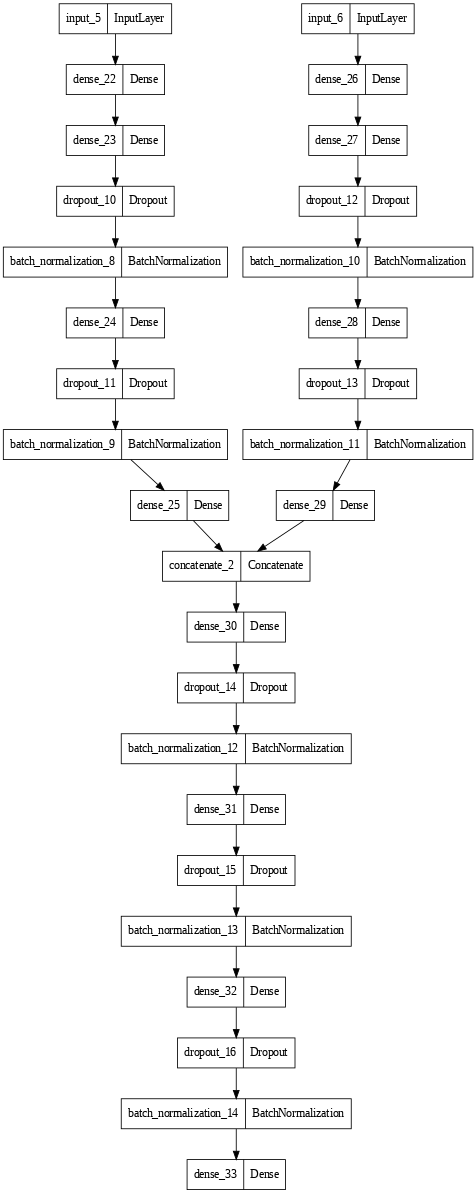

In [119]:
utils.plot_model(model_final, dpi=60)

In [120]:
model_final.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 dense_22 (Dense)               (None, 1000)         1001000     ['input_5[0][0]']                
                                                                                                  
 dense_26 (Dense)               (None, 1000)         1001000     ['input_6[0][0]']                
                                                                                            

Epoch 1/30
176/176 [==============================] - 86s 457ms/step - loss: 1.5450 - accuracy: 0.3533 - val_loss: 0.7722 - val_accuracy: 1.0000
Epoch 2/30
176/176 [==============================] - 80s 453ms/step - loss: 1.3057 - accuracy: 0.4499 - val_loss: 0.7036 - val_accuracy: 0.7443
Epoch 3/30
176/176 [==============================] - 82s 465ms/step - loss: 1.1176 - accuracy: 0.5249 - val_loss: 0.5350 - val_accuracy: 0.8466
Epoch 4/30
176/176 [==============================] - 80s 452ms/step - loss: 1.0028 - accuracy: 0.5838 - val_loss: 0.4048 - val_accuracy: 0.8963
Epoch 5/30
176/176 [==============================] - 79s 451ms/step - loss: 0.8830 - accuracy: 0.6374 - val_loss: 0.2904 - val_accuracy: 0.9631
Epoch 6/30
176/176 [==============================] - 82s 463ms/step - loss: 0.8395 - accuracy: 0.6499 - val_loss: 0.2309 - val_accuracy: 0.9759
Epoch 7/30
176/176 [==============================] - 80s 456ms/step - loss: 0.7776 - accuracy: 0.6825 - val_loss: 0.2050 - val_ac

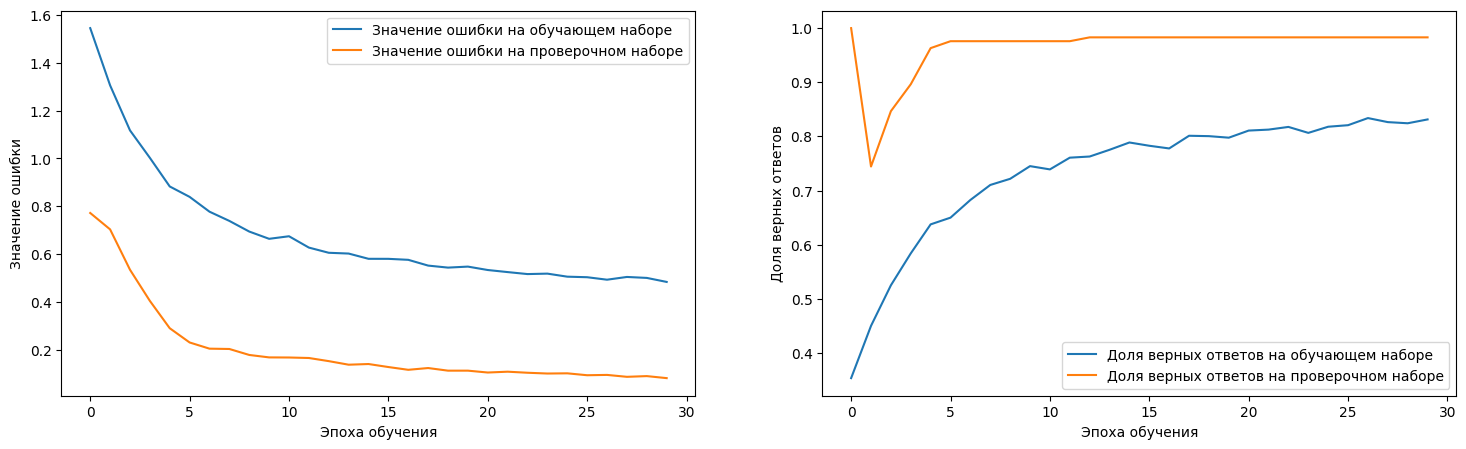

In [121]:
# Обучение модели
model_final.compile(optimizer=Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit([x_train_harm, x_train_Diag], 
                           y_train,
                           shuffle=True,
                           batch_size=16, 
                           epochs=30, 
                           validation_split=0.2,
                           verbose=1)

# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2) 
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей 
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

110/110 [==============================] - 8s 72ms/step


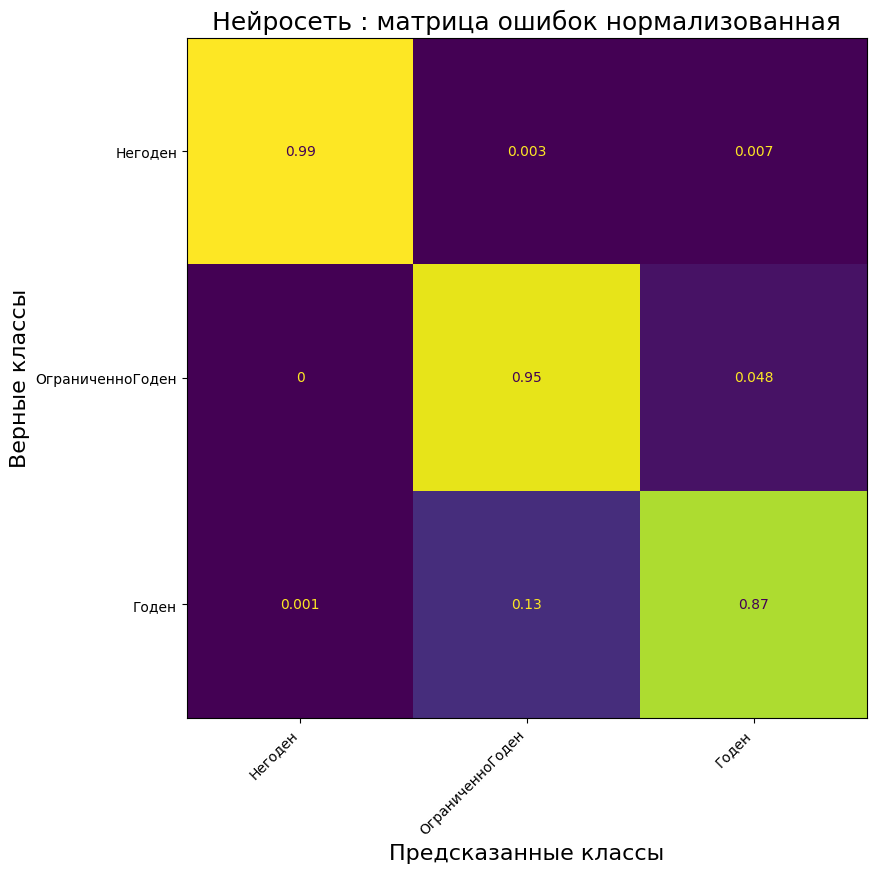

----------------------------------------------------------------------------------------------------
Нейросеть: 

Средняя точность распознавания:  94%


In [122]:
# Запуск предсказания и визуализация
eval_model(model_final, [x_train_harm, x_train_Diag], 
                           y_train, class_labels = CLASS_DICT)

In [124]:
# Пример предсказания

# обновляем номера индексов
dffix5=dffix5.reset_index(drop=True)
           
indexes_0 = dffix5.loc[dffix5['ЗаключениеМК'] == 'Негоден'].index.tolist()
indexes_1 = dffix5.loc[dffix5['ЗаключениеМК'] == 'ОграниченноГоден'].index.tolist()
indexes_2 = dffix5.loc[dffix5['ЗаключениеМК'] == 'Годен'].index.tolist()

n_0 = random.choice(indexes_0)
n_1 = random.choice(indexes_1)
n_2 = random.choice(indexes_2)

y_pred = model_final.predict([x_train_harm, x_train_Diag])

y = np.argmax(y_pred, axis=-1)

df_pred = pd.DataFrame({'Реальное заключение': ['Негоден', 'ОграниченноГоден', 'Годен'],
                   'Реальный вектор': [y_train[n_0], y_train[n_1], y_train[n_2]],
                   'Реальный класс': [y_data[n_0], y_data[n_1], y_data[n_2]],
                   'Предсказанный вектор': [y_pred[n_0], y_pred[n_1], y_pred[n_2]],
                   'Предсказанный класс': [y[n_0], y[n_1], y[n_2]],
                   'Вредный фактор': [dffix5.iloc[n_0][1], dffix5.iloc[n_1][1], dffix5.iloc[n_2][1]],
                   'Сводный диагноз': [dffix5.iloc[n_0][2], dffix5.iloc[n_1][2], dffix5.iloc[n_2][2]]
                   })
df_pred

110/110 [==============================] - 10s 88ms/step


,Реальное заключение,Реальный вектор,Реальный класс,Предсказанный вектор,Предсказанный класс,Вредный фактор,Сводный диагноз
0,Негоден,"[1.0, 0.0, 0.0]",0,"[0.89455277, 0.08824605, 0.017201172]",0,4.2.3,Выраженные расстройства вегетативной автономно...
1,ОграниченноГоден,"[0.0, 1.0, 0.0]",1,"[0.013916052, 0.98339224, 0.0026917479]",1,13,"Общий медицинский осмотр,Общий медицинский осм..."
2,Годен,"[0.0, 0.0, 1.0]",2,"[0.032430455, 0.051007114, 0.9165624]",2,9,"Общий медицинский осмотр,Общий медицинский осм..."
